# Report results

### Task
- Plot learning curve
- Calculate the average validation loss and accuracy for the last epoch

### Optional
- Figure out why tracker only records the first epoch

In [9]:
%load_ext autoreload
%autoreload 2

import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

import config
from data import VQA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# config
experiments = [
    ("mlp_c_only_15epochs", "2024_04_29_08_21_29", 15), 
    ("mlp_qc_only_15epochs", "2024_04_28_04_27_13", 15), 
    ("mlp_data_15epochs", "2024_04_29_11_47_10", 15), 
    ("ewm_mlp_data_15epochs", "2024_04_29_18_01_09", 15), 
    ("ewa_mlp_data_15epochs", "2024_04_29_20_46_07", 15), 
    ("attention_data_15epochs", "2024_04_27_03_36_04", 15), 
]
exp_names = ["MLP with C-only", "MLP with QC-only", "MLP with all-inputs", "MLP with all-inputs by EW-Mult", "MLP with all-inputs by EW-Add", "MLP with all-inputs + attention"]

In [56]:
# all avgs
def compute_epoch_metrics(exp_prefix, exp_time, exp_epochs):
    # avg metrics for every epoch for the curves
    avg_metrics_per_epoch_dict = {
        "losses_val": [], 
        "overall_accs_val": [], 
        "losses_train": [], 
        "overall_accs_train": [], 
    }
    # preds and truth for last val epoch for final metrics reporting
    y_preds_val = []
    y_true_val = []
    q_ids_val = []
    idx_val = []
    for epoch_num in range(exp_epochs):
        exp_filepath = os.path.join("logs", exp_prefix, f"{exp_prefix}_{exp_time}_{epoch_num}.pth")
        logs_dict = torch.load(exp_filepath, map_location=torch.device('cpu'))
        metric_names = avg_metrics_per_epoch_dict.keys()
        for metric_name, batch_metrics in logs_dict["eval"].items():
            if metric_name in metric_names:
                avg_metric = np.mean(batch_metrics)
                avg_metrics_per_epoch_dict[metric_name].append(avg_metric)
            elif epoch_num == exp_epoch - 1 and metric_name == "y_preds_val":
                y_preds_val.append(batch_metrics)
            elif epoch_num == exp_epoch - 1 and metric_name == "y_true_val":
                y_true_val.append(batch_metrics)
            elif epoch_num == exp_epoch - 1 and metric_name == "q_ids_val":
                q_ids_val.append(batch_metrics)
            elif epoch_num == exp_epoch - 1 and metric_name == "idx_val":
                idx_val.append(batch_metrics)
    
    y_preds_val = np.array(torch.cat(y_preds_val, dim=0))
    y_true_val = np.array(torch.cat(y_true_val, dim=0))
    q_ids_val = np.array(torch.cat(q_ids_val, dim=0))
    idx_val = np.array(torch.cat(idx_val, dim=0))
    return avg_metrics_per_epoch_dict, y_preds_val, y_true_val, q_ids_val, idx_val

all_avg_metrics_per_epoch_dict = {}
final_metrics_dfs = {}
with open(config.ANNOTATIONS_VAL_FILEPATH, 'r') as fd:
    answers_json = json.load(fd)
qid_to_qtype = {a_dict["question_id"]: a_dict["question_type"] for a_dict in answers_json["annotations"]}
questions_path = config.QUESTIONS_VAL_FILEPATH
answers_path = config.ANNOTATIONS_VAL_FILEPATH
image_features_path = config.PREPROCESSED_VAL_FILEPATH
val_input_data = VQA(
    questions_path, 
    answers_path, 
    image_features_path, 
)
for exp_prefix, exp_time, exp_epoch in experiments:
    # for learning curve
    avg_metrics_per_epoch_dict, y_preds_val, y_true_val, q_ids_val, idx_val = compute_epoch_metrics(exp_prefix, exp_time, exp_epoch)
    all_avg_metrics_per_epoch_dict[exp_prefix] = avg_metrics_per_epoch_dict

    # for final val metrics reporting
    val_data = pd.DataFrame({
        "y_pred": y_preds_val, 
        "y_true": y_true_val, 
        "q_ids": q_ids_val, 
        "idx": idx_val, 
    })
    val_data["q_type"] = val_data["q_ids"].apply(lambda x: qid_to_qtype[x])
    val_data["answer_str"] = val_data["idx"].apply(lambda x: val_input_data.qca[x]["answer_str"])
    final_metrics_dfs[exp_prefix] = val_data

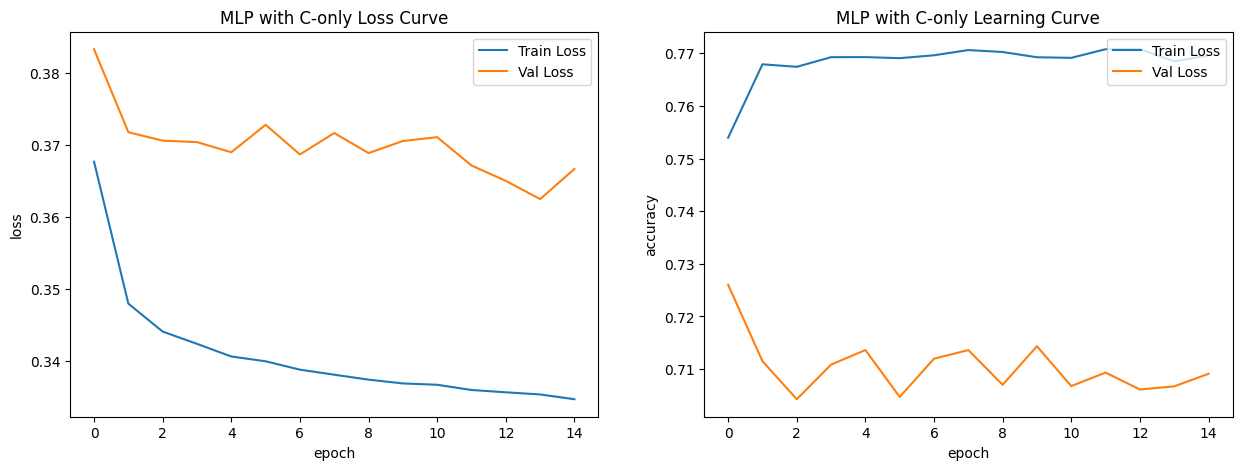

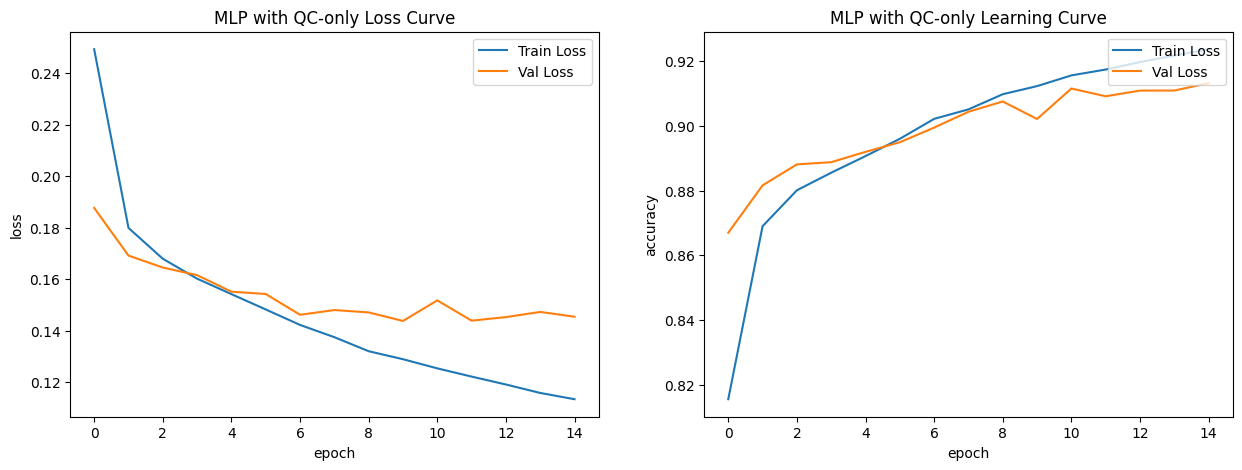

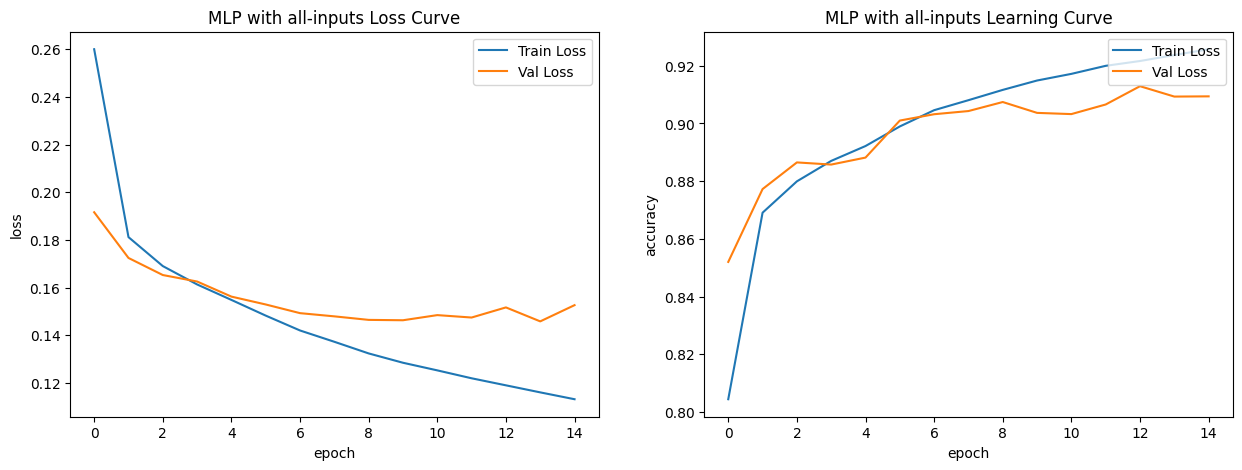

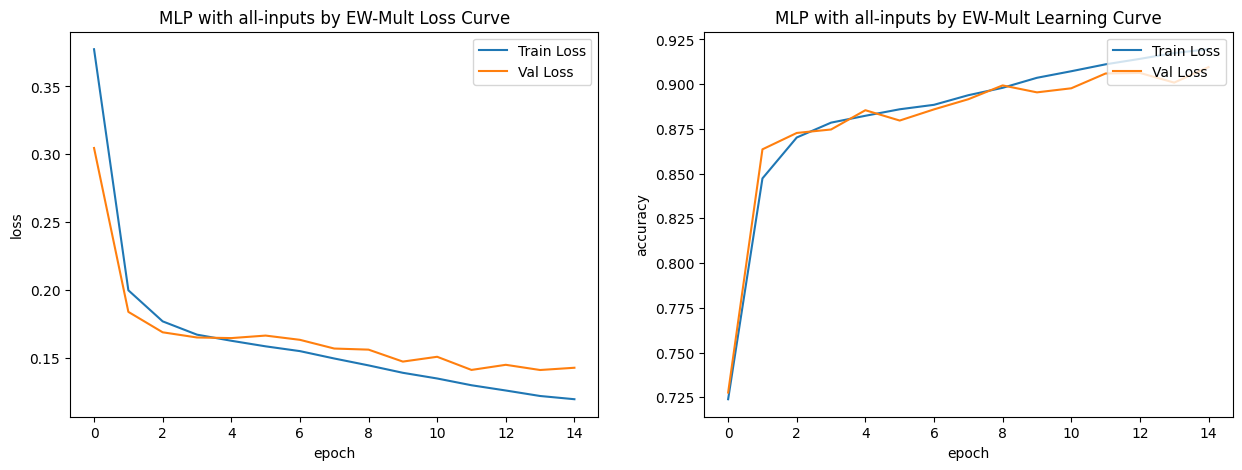

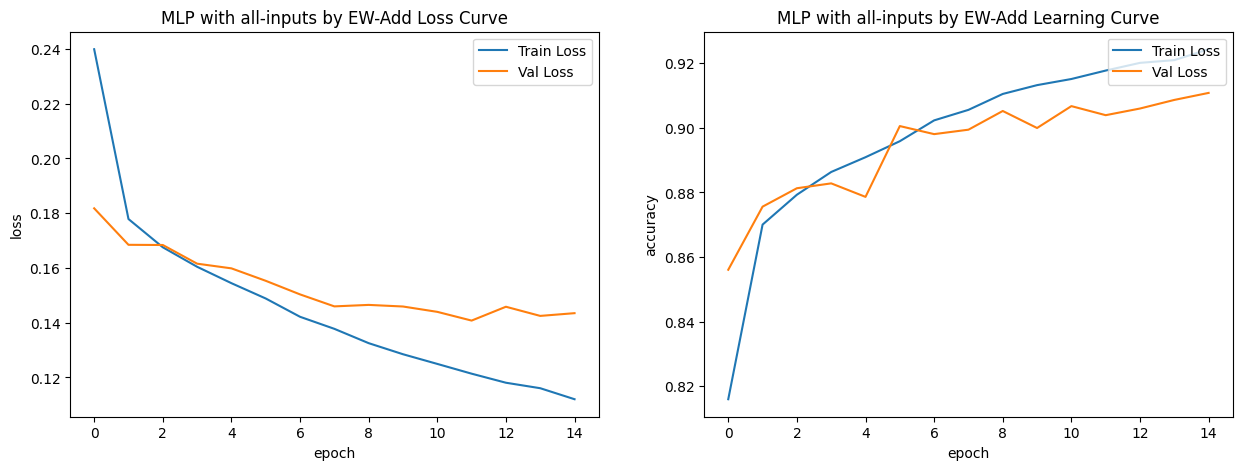

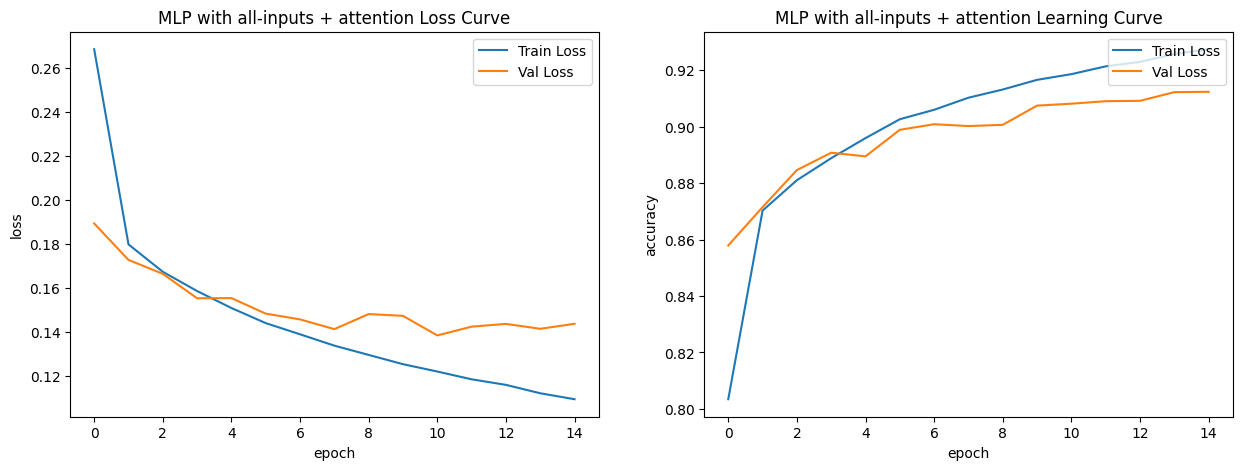

In [57]:
# plot
last_val_metrics = {}
for exp_name, (exp_prefix, exp_dict) in zip(exp_names, all_avg_metrics_per_epoch_dict.items()):
    # collect val metrics for last epoch
    last_val_metrics[exp_prefix] = {}
    for metric_name, epochs_data in exp_dict.items():
        if metric_name.endswith("_val"):
            last_val_metrics[exp_prefix][metric_name] = epochs_data[-1]

    x = list(range(len(exp_dict["losses_train"])))
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(x, exp_dict["losses_train"], label="Train Loss")
    ax[0].plot(x, exp_dict["losses_val"], label="Val Loss")
    ax[0].legend(loc="upper right")
    ax[0].set_title(f"{exp_name} Loss Curve")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[1].plot(x, exp_dict["overall_accs_train"], label="Train Loss")
    ax[1].plot(x, exp_dict["overall_accs_val"], label="Val Loss")
    ax[1].legend(loc="upper right")
    ax[1].set_title(f"{exp_name} Learning Curve")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    plt.show()

In [58]:
# overall final metrics by averaging the mean batch metrics for the last epoch
pd.DataFrame(last_val_metrics).T

,losses_val,overall_accs_val
mlp_c_only_15epochs,0.366638,0.709106
mlp_qc_only_15epochs,0.145463,0.913230
mlp_data_15epochs,0.152674,0.909402
ewm_mlp_data_15epochs,0.142911,0.909546
ewa_mlp_data_15epochs,0.143478,0.910844
attention_data_15epochs,0.143769,0.912398


In [59]:
# Final val epoch metrics by question type calculation from scratch
def is_number(x):
    try:
        int(x)
        return 1
    except ValueError:
        return 0

last_val_metrics_by_question_type = {}
for exp_name, df in final_metrics_dfs.items():
    df["yes_no_cat"] = df["answer_str"].apply(lambda x: 1 if x in ["yes", "no"] else 0)
    df["number_cat"] = df["answer_str"].apply(lambda x: is_number(x))
    df["other_cat"] = df.apply(lambda row: 1 if row["yes_no_cat"] == 0 and row["number_cat"] == 0 else 0, axis=1)
    yes_no_cat_df = df[df["yes_no_cat"] == 1]
    yes_no_cat_acc = accuracy_score(yes_no_cat_df.y_true, np.round(yes_no_cat_df.y_pred))
    number_cat_df = df[df["number_cat"] == 1]
    number_cat_acc = accuracy_score(number_cat_df.y_true, np.round(number_cat_df.y_pred))
    other_cat_df = df[df["other_cat"] == 1]
    other_cat_acc = accuracy_score(other_cat_df.y_true, np.round(other_cat_df.y_pred))
    overall_acc = accuracy_score(df.y_true, np.round(df.y_pred))
    last_val_metrics_by_question_type[exp_name] = {
        "Number": number_cat_acc, 
        "Yes/No": yes_no_cat_acc, 
        "Other": other_cat_acc, 
        "Overall": overall_acc, 
    }

In [60]:
pd.DataFrame(last_val_metrics_by_question_type).T

,Number,Yes/No,Other,Overall
mlp_c_only_15epochs,0.620148,0.802556,0.651263,0.709211
mlp_qc_only_15epochs,0.863901,0.960824,0.884858,0.913200
mlp_data_15epochs,0.858243,0.959853,0.878960,0.909367
ewm_mlp_data_15epochs,0.854550,0.960393,0.880129,0.909589
ewa_mlp_data_15epochs,0.859029,0.959584,0.882195,0.910811
attention_data_15epochs,0.847635,0.960878,0.888093,0.912367
